# Introduction to Radiation Dosage Computation from Galactic Cosmic Rays (GCR)

## Overview

Radiation detectors such as RADEM play a crucial role in measuring and analyzing various types of radiation in our environment, especially in space applications where exposure to cosmic radiation is a significant concern. Among the different sources of radiation, Galactic Cosmic Rays (GCR) are high-energy particles that originate from outside our solar system.

In this Jupyter Notebook, we will demonstrate how to compute the total dosage deposited on a radiation detector based on the GCR spectrum. Using RADEM data we'll isolate periods of solar activity from the measurements assuring that we've only counted GCR particles into our analysis. This information might be critical for evaluating the effectiveness of radiation shielding, monitoring astronaut safety during space missions, and advancing our understanding of space radiation hazards.

## Importing required dependencies
To perform this analysis we'll have to import a few tools. This also includes the `radem` library.

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import radem

from typing import Tuple
import datetime


## Loading data
We'll base our analysis on the proton data from the RADEM detector.


In [71]:
protons_df = radem.loaders.load_csv("../../../data/protons.csv")
print(protons_df.head())

                 time  bin  value
0 2023-09-01 00:00:56    1      6
1 2023-09-01 00:00:56    2    222
2 2023-09-01 00:00:56    3     27
3 2023-09-01 00:00:56    4     21
4 2023-09-01 00:00:56    5     18


## Selecting the Correct Time Interval for Analysis
Selecting an appropriate time window is crucial, as it directly influences the integrity of the analysis outcomes.

Calibration artifacts — periods when instruments are being adjusted or tested, can introduce misleading signals that do not accurately represent the true radiation environment. Similarly, instances when detectors are down for maintenance can lead to gaps or inaccuracies in the data. These factors can obscure meaningful trends and potentially lead to incorrect conclusions about radiation exposure or environmental conditions. Additionally we have to consider the trends in our data when using background detection algorithms such as the one in this example.

For the purpouses of this analysis we'll be using the period from 2023-09-01 to 2024-01-01. 

In [72]:
def select_bin(df: pd.DataFrame, bin: int) -> pd.DataFrame:
    result = df[df['bin'] == bin]
    result = result.drop(columns = ["bin"])
    result = result.reset_index()
    return result

In [73]:
bin = 1
df = select_bin(protons_df, bin = 1)
df = df[(df['time'] > '2023-09-01') & (df['time'] < '2024-01-01')]
print(df)

          index                time  value
0             0 2023-09-01 00:00:56      6
1            16 2023-09-01 00:01:56      9
2            25 2023-09-01 00:02:56      4
3            35 2023-09-01 00:03:56      4
4            43 2023-09-01 00:04:56      7
...         ...                 ...    ...
175683  1581155 2023-12-31 23:55:31     13
175684  1581163 2023-12-31 23:56:31     14
175685  1581173 2023-12-31 23:57:31     12
175686  1581182 2023-12-31 23:58:31     13
175687  1581191 2023-12-31 23:59:31     14

[175688 rows x 3 columns]


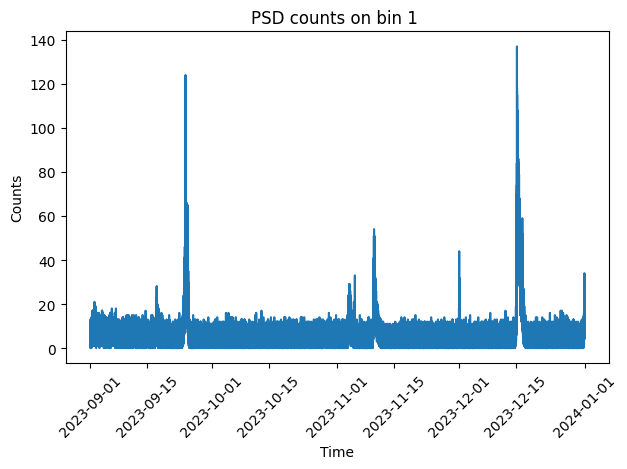

In [74]:
plt.plot(df['time'], df['value'])
plt.xlabel("Time")
plt.ylabel("Counts")
plt.title(f"PSD counts on bin {bin} ")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Filtering Solar Events to Ensure GCR-Only Data
When analyzing cosmic radiation, particularly the Galactic Cosmic Ray (GCR) spectrum, it is crucial to remove periods of solar activity from the data. Solar energetic particles (SEPs) generated during solar flares or coronal mass ejections (CMEs) can significantly distort the measurements, as these high-energy particles are much more intense and short-lived than the background GCR spectrum. If not filtered out, solar events can lead to inaccurate estimates of radiation dosage and skewed interpretations of cosmic ray behavior.

To ensure that the data we analyze reflects only the GCR spectrum, we must first identify and remove the periods of solar events. This process involves leveraging certain characteristics of solar particle events that distinguish them from the GCR background, such as sudden increases in particle flux.

We can use the `background` module in the `radem` library to do just that.

In [75]:
def get_background_intervals(df: pd.DataFrame, interval: Tuple[datetime.datetime, datetime.datetime]):
    df = df[(df['time'] >= interval[0]) & (df['time'] <= interval[1])]

    offsets =  [2 * 24 * 60]
    mask = radem.events.noise_mask(df, rolling_window=2 * 24 * 60, offsets=offsets, full_interval=interval)
    intervals = radem.events.intervals_from_mask(mask)

    # noise = df[mask]
    # noise["noise"] = noise["value"] + 1000.0
    df = df.reset_index()
    time = df["time"]

    return intervals

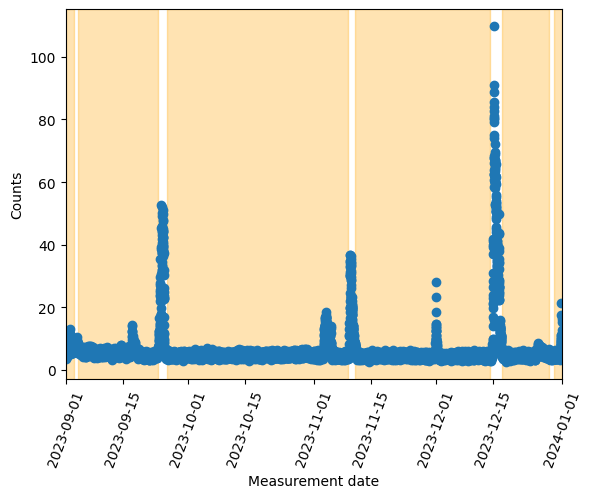

In [76]:
full_interval = datetime.datetime(2023, 9, 1), datetime.datetime(2024, 1, 1)
background_intervals = get_background_intervals(df, full_interval)
time = df['time']

for start, end in background_intervals:
    plt.axvspan(time[start], time[end-1], color='orange', alpha=0.3)

df = df.resample("15min", on='time').mean()
df = df.reset_index()

plt.xlabel("Measurement date")
plt.ylabel("Counts")
plt.xticks(rotation=70)
plt.xlim(full_interval)
plt.scatter(x=df["time"], y=df["value"])
plt.show()

In [77]:
# Iterate over the list of intervals and set values to zero inside these intervals
for start, end in background_intervals:
    df.loc[start:end, 'value'] = 0  # Set the 'value' column (index 1) to zero